# Custom TransferLearning using InceptionV3

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD

from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Carga de los datos para el entrenamiento

In [3]:
img_size = 224
path_train = 'data/train_with_background'
path_test_validation = 'data/validation_224'

In [4]:
map_labels = {
    0: '20', 
    1: '100'
}
num_classes = len(map_labels)
print(num_classes)

2


# Metodo para cargar los datos

In [5]:
def load_set(dirname, map_labels, verbose=True):
    X_train = []
    y_train = []
    for id_label, label in map_labels.items():        
        files = os.listdir(os.path.join(dirname, label))
        images = [file for file in files if file.endswith("png")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), label))
        for image_name in images:
            path = os.path.join(dirname, label, image_name)
            image = cv2.imread(path)
            X_train.append(cv2.resize(image,(img_size, img_size)))
            y_train.append(id_label)
    return np.array(X_train), np.array(y_train)

In [6]:
print("train data")
train_data, train_labels = load_set(path_train, map_labels)
print("validation data")
validation_data, validation_labels = load_set(path_test_validation, map_labels)

train data
Leyendo 3000 imágenes encontradas de 20
Leyendo 3000 imágenes encontradas de 100
validation data
Leyendo 1367 imágenes encontradas de 20
Leyendo 1444 imágenes encontradas de 100


# Normalizamos los valores

In [7]:
train_data = train_data / 255
validation_data = validation_data / 255

In [8]:
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',input_shape=(img_size, img_size, 3)))
#model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
#110

#model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
#model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
#53

#model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, kernel_size=(4, 4), activation='relu'))
#model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
#model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
#model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
#22

#model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu'))
#model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu'))
#model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu'))
#model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
#7

#model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(2048, kernel_size=(3, 3), activation='relu'))
#model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(2048, kernel_size=(3, 3), activation='relu'))
#model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(2048, kernel_size=(3, 3), activation='relu'))
#model.add(ZeroPadding2D((1,1)))
#model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
#model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 128)     3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 256)     295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 256)     590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 512)       2

## Compilamos el modelo

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) #default learning_rate = 0.001
loss = 'sparse_categorical_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=metrics)

In [10]:
epochs = 150
batch_size = 16

history = model.fit(train_data, 
                    train_labels,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data=(validation_data, validation_labels)
                   )

Epoch 1/150
375/375 [==============================] - 176s 470ms/step - loss: 0.6934 - accuracy: 0.4958 - val_loss: 0.6929 - val_accuracy: 0.5137
Epoch 2/150
375/375 [==============================] - 173s 462ms/step - loss: 0.6934 - accuracy: 0.4975 - val_loss: 0.6928 - val_accuracy: 0.5137
Epoch 3/150
375/375 [==============================] - 173s 462ms/step - loss: 0.6935 - accuracy: 0.4907 - val_loss: 0.6933 - val_accuracy: 0.4863
Epoch 4/150
375/375 [==============================] - 173s 462ms/step - loss: 0.6935 - accuracy: 0.4995 - val_loss: 0.6928 - val_accuracy: 0.5137
Epoch 5/150
375/375 [==============================] - 173s 462ms/step - loss: 0.6934 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.4863
Epoch 6/150
375/375 [==============================] - 173s 462ms/step - loss: 0.6934 - accuracy: 0.4985 - val_loss: 0.6933 - val_accuracy: 0.4863
Epoch 7/150
375/375 [==============================] - 173s 462ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0

375/375 [==============================] - 173s 462ms/step - loss: 0.6934 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5137
Epoch 55/150
375/375 [==============================] - 175s 466ms/step - loss: 0.6933 - accuracy: 0.4937 - val_loss: 0.6931 - val_accuracy: 0.5137
Epoch 56/150
375/375 [==============================] - 173s 462ms/step - loss: 0.6931 - accuracy: 0.5040 - val_loss: 0.6931 - val_accuracy: 0.5137
Epoch 57/150
375/375 [==============================] - 173s 462ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6931 - val_accuracy: 0.5137
Epoch 58/150
375/375 [==============================] - 173s 462ms/step - loss: 0.6932 - accuracy: 0.5032 - val_loss: 0.6931 - val_accuracy: 0.5137
Epoch 59/150
375/375 [==============================] - 173s 463ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.5137
Epoch 60/150
375/375 [==============================] - 173s 462ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6931 

375/375 [==============================] - 173s 462ms/step - loss: 0.6931 - accuracy: 0.5057 - val_loss: 0.6932 - val_accuracy: 0.4863
Epoch 110/150
375/375 [==============================] - 173s 462ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5137
Epoch 111/150
375/375 [==============================] - 173s 462ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6931 - val_accuracy: 0.5137
Epoch 112/150
375/375 [==============================] - 173s 462ms/step - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5137
Epoch 113/150
375/375 [==============================] - 173s 462ms/step - loss: 0.6932 - accuracy: 0.4968 - val_loss: 0.6931 - val_accuracy: 0.5137
Epoch 114/150
375/375 [==============================] - 173s 462ms/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6931 - val_accuracy: 0.4863
Epoch 115/150
375/375 [==============================] - 173s 462ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0

## Creando un gráfico para la revisión

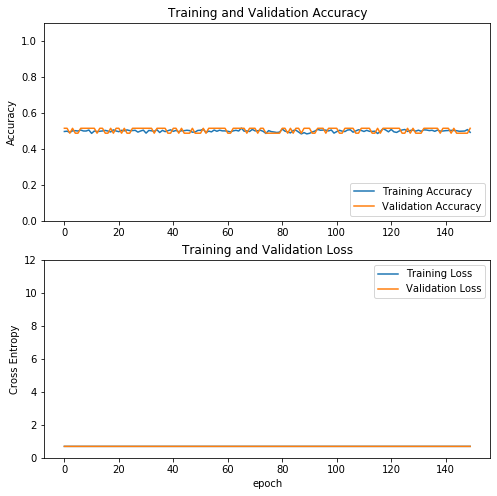

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.ylim([0,12])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Guardando el modelo

In [ ]:
saved_model_dir = 'model'
tf.saved_model.save(model, saved_model_dir)

## Convirtiendo el modelo en tensorflow lite para el uso en mobile

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

path_tensorflow_lite = 'model_tflite/vgg19_model.tflite'
with open(path_tensorflow_lite, 'wb') as f:
  f.write(tflite_model)

# Tomando 25 imágenes de validación y observando el resultado

INFO:tensorflow:Load image with size: 2811, num_label: 2, labels: 100, 20.


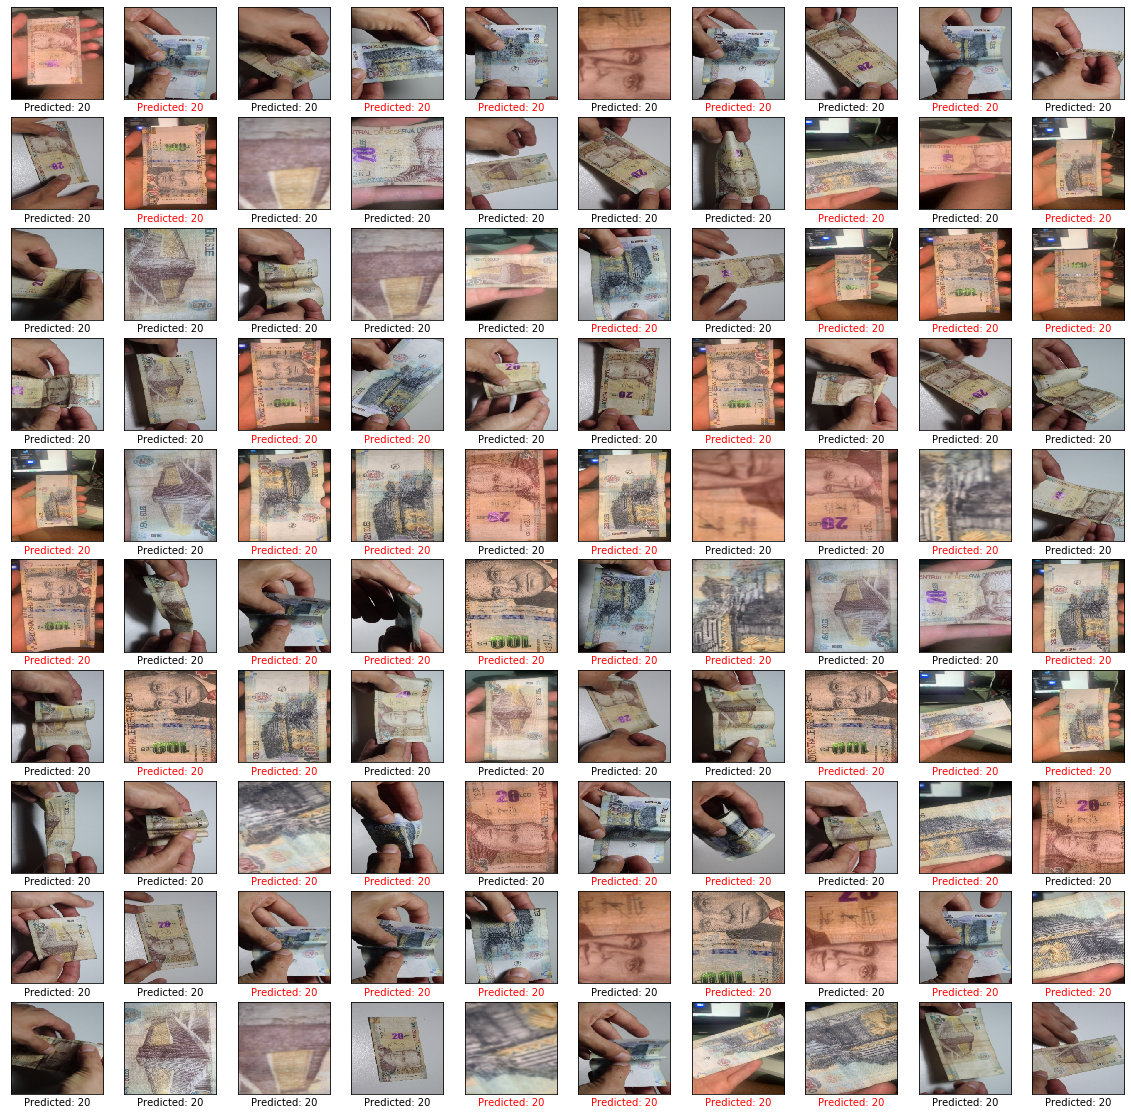

In [14]:
test_data = ImageClassifierDataLoader.from_folder(path_test_validation)

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(test_data.dataset.take(100)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)

    swapped = np.moveaxis(image, 0, 1)
    arr4d = np.expand_dims(swapped, 0)
    id_predict = np.argmax(model.predict(arr4d))
    
    predict_label = "100"
    if id_predict == 1:
        predict_label = "20"
    color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
    #color = 'black'
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predict_label)
plt.show()